# Data set

In [9]:
import pandas as pd
# using only 500 rows
text_df = pd.read_csv(r'C:\Users\rohits12\Desktop\Word2Vec\Discharge summary word2vec\dischargeSummary_10K.csv',
                      usecols=['text'],nrows=500)

In [10]:
text_df.head(3)

,text
0,\n\n
1,"""\n\nAdmission Date: [**3157-9-18**] Di..."
2,"""\n\nAdmission Date: [**2984-9-25**] Disc..."


# Preprocessing

## checking for null data

In [11]:
text_df.isnull().sum()

text    190
dtype: int64

In [12]:
text_df.dropna(inplace=True)

In [13]:
text_df.isnull().sum()

text    0
dtype: int64

## Cleaning

In [155]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [99]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    
    txt = [token for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return ' '.join(str(v) for v in txt).strip()

In [100]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in text_df['text'])

In [101]:
from time import time
import re
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=10, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t)/60, 2)))

Time to clean up everything: 34.94 mins


In [102]:
# import spacy
# nlp = spacy.load('en', disable=['ner', 'parser'])

In [143]:
print("before cleaning empty string="+str(len(txt)))
# removing empty strings from the list
while '' in txt:
    txt.remove('')
print("after cleaning empty string="+str(len(txt)))

before cleaning empty string=258
before cleaning empty string=258


In [162]:
# nlp.disable_pipes('ner', 'parser')

In [163]:
# nlp.pipe_names

In [164]:
# parsed_review =nlp(text_df.iloc[1]['text'])

In [165]:
# for num,sen in enumerate(parsed_review.sents):
#     print(num)
#     print(sen)

In [166]:
# for num,sen in enumerate(parsed_review.ents):
#     print(num)
#     print(sen)
#     print(sen.label_)

In [167]:
df_clean = pd.DataFrame({'clean': txt})

In [168]:
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(258, 1)

## Bigrams

In [169]:
from gensim.models.phrases import Phrases, Phraser

In [171]:
sent = [row.split() for row in df_clean['clean']]

In [173]:
sent[0]

['admission',
 'date',
 'discharge',
 'date',
 'date',
 'birth',
 'sex',
 'm',
 'service',
 'nb',
 'history',
 'present',
 'illness',
 'known',
 'patient',
 'lastname',
 'known',
 'patient',
 'lastname',
 'kg',
 'product',
 'weeks',
 'gestation',
 'pregnancy',
 'born',
 'year',
 'old',
 'g',
 'p',
 'woman',
 'prenatal',
 'screens',
 'blood',
 'type',
 'o',
 'positive',
 'antibody',
 'negative',
 'rubella',
 'immune',
 'rpr',
 'nonreactive',
 'hepatitis',
 'b',
 'surface',
 'antigen',
 'negative',
 'group',
 'beta',
 'strep',
 'status',
 'unknown',
 'pregnancy',
 'uncomplicated',
 'mother',
 'presented',
 'repeat',
 'elective',
 'cesarean',
 'section',
 'previous',
 'ob',
 'history',
 'notable',
 'cesarean',
 'sections',
 'infant',
 'born',
 'hours',
 'noted',
 'retractions',
 'birth',
 'transferred',
 'neonatal',
 'intensive',
 'care',
 'unit',
 'observation',
 'monitoring',
 'required',
 'blow',
 'oxygen',
 'apgars',
 'minute',
 'minutes',
 'physical',
 'examination',
 'admission',
 '

In [208]:
phrases = Phrases(sent, min_count=1, progress_per=100)

In [209]:
bigram = Phraser(phrases)

In [204]:
sentences = bigram[sent]

In [213]:
for sen1 in sentences:
    print(sen1)
    break;

['admission_date', 'discharge_date', 'date_birth', 'sex_m', 'service_nb', 'history_present', 'illness', 'known_patient', 'lastname', 'known_patient', 'lastname', 'kg', 'product', 'weeks_gestation', 'pregnancy', 'born', 'year_old', 'g', 'p', 'woman', 'prenatal_screens', 'blood_type', 'o', 'positive_antibody', 'negative', 'rubella_immune', 'rpr_nonreactive', 'hepatitis_b', 'surface_antigen', 'negative', 'group', 'beta', 'strep', 'status', 'unknown', 'pregnancy', 'uncomplicated', 'mother', 'presented', 'repeat', 'elective', 'cesarean_section', 'previous', 'ob', 'history', 'notable', 'cesarean', 'sections', 'infant', 'born', 'hours', 'noted', 'retractions', 'birth', 'transferred', 'neonatal_intensive', 'care_unit', 'observation', 'monitoring', 'required', 'blow', 'oxygen', 'apgars', 'minute_minutes', 'physical_examination', 'admission', 'neonatal_intensive', 'care_unit', 'weight', 'kg', 'length_cm', 'head_circumference', 'cm_th', 'th_percentile', 'gestational_age', 'general', 'infant', 'ap

# Training the model

In [214]:
import multiprocessing
from gensim.models import Word2Vec

In [215]:
cores = multiprocessing.cpu_count()

In [216]:
cores

8

In [242]:
w2v_model = Word2Vec(min_count=20,
                     window=10,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

C:\Users\rohits12\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [243]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [244]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.99 mins


In [248]:
w2v_model.wv.most_similar('diabetes')

[('femur', 0.9999837875366211),
 ('bilaterally', 0.9999837875366211),
 ('patient', 0.9999837279319763),
 ('renal', 0.9999834895133972),
 ('artery', 0.9999833703041077),
 ('fluid', 0.9999833106994629),
 ('week', 0.9999833106994629),
 ('placed', 0.9999828338623047),
 ('normal', 0.9999828338623047),
 ('mg_p', 0.9999827146530151)]

In [246]:
w2v_model.wv.vocab

{'admission_date': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfbe0>,
 'discharge_date': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf1d0>,
 'date_birth': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfc18>,
 'sex_m': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf0b8>,
 'history_present': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfd68>,
 'illness': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf160>,
 'known_patient': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfe10>,
 'lastname': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf9b0>,
 'kg': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfa58>,
 'pregnancy': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfba8>,
 'born': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf2b0>,
 'year_old': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf780>,
 'g': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf748>,
 'p': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcfd30>,
 'woman': <gensim.models.keyedvectors.Vocab at 0x1ee9fdcf7b8>,
 'prenatal_scr

In [249]:
w2v_model.wv.similarity('patient','pt')

0.99999404

In [251]:
w2v_model.wv.doesnt_match(['patient','pt','feedings'])

C:\Users\rohits12\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'feedings'

# Visualization

In [255]:
import numpy as np

#Important Parameters
VOCAB_SIZE = len(w2v_model.wv.vocab)
EMBEDDING_DIM = w2v_model["died"].shape[0]

w2v = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

C:\Users\rohits12\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [259]:
FOLDER_PATH = "C:/Users/rohits12/Desktop/Word2Vec"
tsv_file_path = FOLDER_PATH+"/tensorboard/metadata.tsv"
with open(tsv_file_path,'w+', encoding='utf-8') as file_metadata:
    for i,word in enumerate(w2v_model.wv.index2word[:VOCAB_SIZE]):
        w2v[i] = w2v_model.wv[word]
        file_metadata.write(word+'\n')

In [260]:
import tensorflow as tf
tf.reset_default_graph()
from tensorflow.contrib.tensorboard.plugins import projector

In [261]:
X_init = tf.placeholder(tf.float32, shape=(VOCAB_SIZE, EMBEDDING_DIM), name="embedding")
X = tf.Variable(X_init)

Instructions for updating:
Colocations handled automatically by placer.


In [262]:
init = tf.global_variables_initializer()

In [263]:
TENSORBOARD_FILES_PATH = FOLDER_PATH+"/tensorboard"

In [264]:

#Start Tensorflow Session
sess = tf.Session()
sess.run(init, feed_dict={X_init: w2v})


#Instance of Saver, save the graph.
saver = tf.train.Saver()
writer = tf.summary.FileWriter(TENSORBOARD_FILES_PATH, sess.graph)

In [265]:
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.metadata_path = tsv_file_path

#Write a projector_config
projector.visualize_embeddings(writer,config)

#save a checkpoint
saver.save(sess, TENSORBOARD_FILES_PATH+'/model.ckpt', global_step = VOCAB_SIZE)

#close the session
sess.close()

# # command to run for tensorboard
 tensorboard --logdir=="C:\Users\rohits12\Desktop\Word2Vec\tensorboard" --host=127.0.0.1

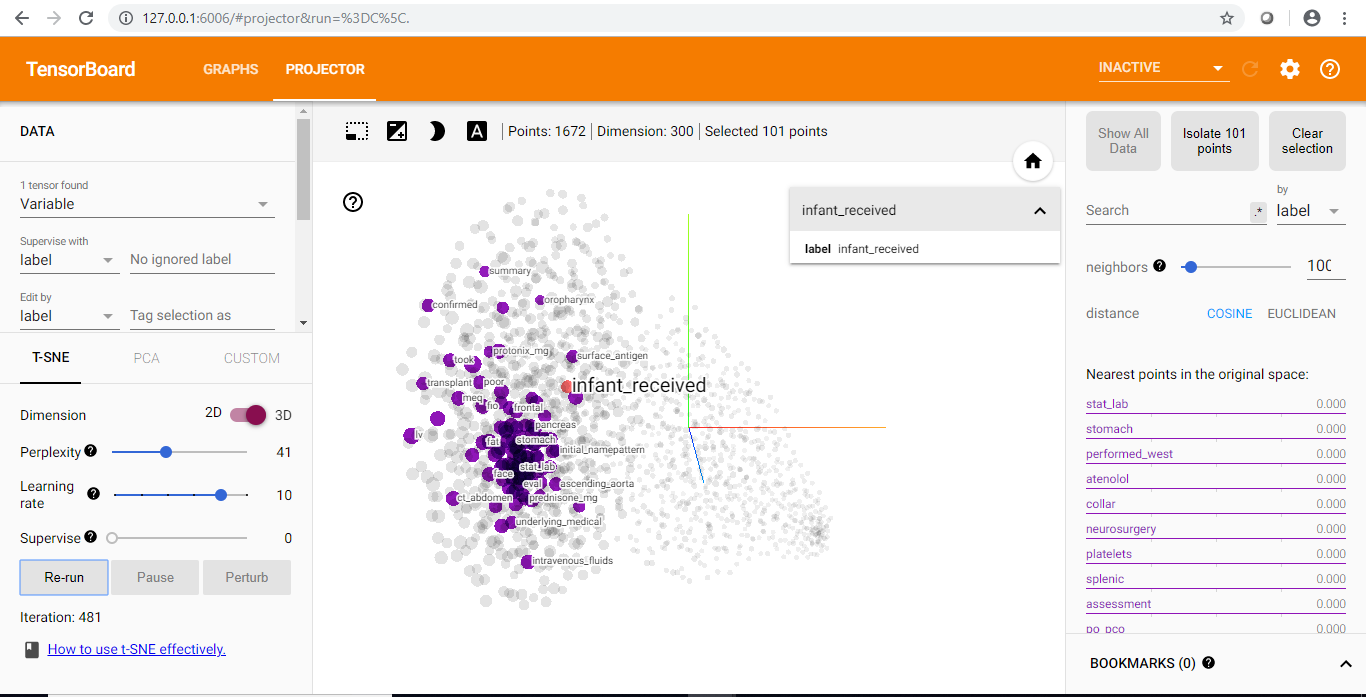

In [266]:
from IPython.display import Image
Image(filename='tensorboard.png')

# Fast text

In [267]:
from gensim.models.fasttext import FastText

In [270]:
fasttext_model = FastText(size=100)

C:\Users\rohits12\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [272]:
# build the vocabulary
fasttext_model.build_vocab(sentences)

In [274]:
t = time()

fasttext_model.train(sentences, total_examples=fasttext_model.corpus_count, epochs=1, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 8.35 mins


In [278]:
print("birth" in fasttext_model.wv.vocab)
print("bith" in fasttext_model.wv.vocab)

True
False


In [279]:
fasttext_model.similarity("birth", "bith")

C:\Users\rohits12\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.9997908

In [284]:
fasttext_model.wv.most_similar('dehydration')

[('hydration', 0.9999995231628418),
 ('inspiration', 0.9999992847442627),
 ('ulceration', 0.9999991655349731),
 ('duration', 0.9999991655349731),
 ('gestation', 0.9999990463256836),
 ('resuscitation', 0.9999990463256836),
 ('operation', 0.9999990463256836),
 ('laceration', 0.9999990463256836),
 ('ligation', 0.9999989867210388),
 ('regurgitation', 0.9999989867210388)]